In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
from scipy import signal
from scipy.signal import find_peaks
import os

In [ ]:
#A function that opens the file and separates each of the four columns, removes the bias and current offsets,
#and removes the voltage drop from the femto and lines

#Input arguments:
#path: define the file location and the file in the form: "\filelocation\filename"
#dc_fac: DC factor can be found in the lab notebook
#femto: gain setting (V/A)
#R: resistor in the lock-in (Ohms)

#returns:
#v_corr: corrected voltage bias. Offset and line voltage drop removed
#dI_dV: corrected conductance spectrum. differentiated g_int wrt v_corr
#g_oop: untreated out-of-plane conductance
#g_int: integral of g. representative of the 

def remove_Rs(path, dc_fac, femto, R):
    
    with open(path) as f:
        lines = f.readlines()
        x0 = [float(line.split()[0]) for line in lines]
        x1 = [float(line.split()[1]) for line in lines]
        x2 = [float(line.split()[2]) for line in lines]
        y1 = [float(line.split()[3]) for line in lines]
        
    v = [x*dc_fac for x in x0]           #raw data bias
    g = [y1/femto/R for y1 in x1]        #raw data conductance (S)
    g_oop = [y1/femto/R for y1 in x2]    #raw data out-of-plane conductance (S)
    i_raw = [z/femto for z in y1]            #raw data current (A)
    
    #Using the scipy.signal.peakfind, we next identify the indices of the peaks (peakind) 
    peakind, properties = find_peaks(g, distance=750, prominence=(2e-05, 5.33296e-03))  # when the function does not work, distance may often help
        
    #Visualization 1
    #plt.plot([x*1e3 for x in v],[y*1e3 for y in g], color='black', label='g(v_bias) raw data')
    
    #for i in range(0,len(peakind)):
    #    plt.plot(v[peakind[i]]*1e3, g[peakind[i]]*1e3, 'x')
        
    #plt.xlabel("Voltage bias (mV)")
    #plt.ylabel("g (mS)")
        
    print(peakind)
    #print(properties)
    
    if len(peakind) == 2:
                
        #The center of the peaks corresponds to the bias offset
        v_offset = (v[peakind[1]]+v[peakind[0]])*0.5
        #print (v_offset)
    
        #Removing the offset from the data
        v_bare = [x-v_offset for x in v]
        
        #Visualization 2
        #plt.plot([x*1e3 for x in v],[y*1e3 for y in g], color='black', label='raw data')
        #plt.plot([x*1e3 for x in v_bare],[y*1e3 for y in g], color='red', label='bias offset removed')
        #plt.legend()
        #plt.xlim(0.30,0.6)
        #plt.ylim(1.2,1.5)
        #plt.xlabel("Voltage bias (mV)")
        #plt.ylabel("g (mS)")
        
        #Next, remove the current offset using the IV curve. To this, we first use the v_bare to be
        #the x-axis of the IV curve, and from there, we identify the  value of I(0) and force it to be 0.
        
        z=min(np.absolute(v_bare))       #take the absolute value of the a_new and find the minimum, which corresponds to the number closest to zero if it is not zero. 
        
        p = z in v_bare
        
        if p==True:                          #use an if-statement to find the index of that minimum element of v_bare as we took its absolute value to identify the minimum but it can be positive or negative. 
            v_bare_min= v_bare.index(z)      
        else: 
            v_bare_min= v_bare.index(-z)
            
        I_offset= i_raw[v_bare_min]          # I-offset is defined by the current value at the zero bias.
        i_bare = [x-I_offset for x in i_raw]  # d_new is the checked current
        
        #Visualization 3
        #print(z)
        #print(v_bare)
        #print(v_bare_min)
        #print(I_offset)
        #plt.plot([x*1e3 for x in v], [y*1e6 for y in i], color='black')
        #plt.plot([x*1e3 for x in v_bare], [y*1e6 for y in i_bare], color='red')
        #plt.plot([x*1e3 for x in v_bare], [y*1e6 for y in i_bare], color='blue')
        #plt.xlim(-0.1,0.1)
        #plt.ylim(-0.005,0.005)
        #plt.xlabel("Voltage bias (mV)")
        #plt.ylabel("I (uA)")
        
        #For sanity check, we want to integrate g wrt v_bare, and compare it with the (v_bare, i_bare) plot.
        #Ideally, they should be the same but since g is measured with the lock-in, it turns out to be smoother
        #than I, so we must use the integral of g instead of i in succeeding calculation.
        
        g_integration = integrate.cumtrapz(g,v_bare)
        g_integ=np.append(g_integration, g_integration[-1])
        I_offset2 = g_integ[v_bare_min]
        g_int = [x-I_offset2 for x in g_integ]
        
        #visualization4
        #plt.plot([x*1e3 for x in v_bare], [y*1e6 for y in i_bare], color='black', label='current, I')
        #plt.plot([x*1e3 for x in v_bare], [y*1e6 for y in g_int], color='red', label='integrated conductance, g_int')
        #plt.xlabel("Voltage bias (mV)")
        #plt.ylabel("I (uA)")
        #plt.legend()
        
        #Now, we want to remove the voltage drop contribution from the femto and the lines using Kirchoff's rule,
        #and knowing that the femto input impedance is 120 Ohms for 10^6 gain and another 120 Ohms from measuring
        #the lines, which gives a total of 240 Ohms for unwanted voltage drop.
        
        if femto == 1e6:
            R_femto=60
        else :
            R_femto=150
        
        
        R_lines=120
        R_ser= R_femto + R_lines

        v_corr= [y - x*R_ser for y, x in zip(v_bare, g_int)]

        #print(len(g_int))
        #print(len(v_corr))

        #next, we take the derivative of g_int wrt the v_corr

        dI_dV = np.gradient(g_int, v_corr)

        plt.plot([x*1e3 for x in v_bare], [y*1e3 for y in g], color='black', label='raw data')
        plt.plot([x*1e3 for x in v_corr], [y*1e3 for y in dI_dV], color='red', label='R_s removed')
        plt.xlabel('Voltage bias (mV)')
        plt.ylabel('Conductance (mS)')
        #plt.xlim(0.79, 0.80)
        #plt.ylim(1.15, 3.2)
        plt.legend()
        
        
    else:
                
        print('Error: Peakfind properties have to be changed. Copy lines 15 thru 28 on a new cell, and change prominence bound to "(None, 1)". Then open the file with these lines of codes and add print(properties["prominences"], change the prominence bounds inside the function based from these values.')
    
    #fig, axs = plt.subplots(2, 2)
    #axs[0, 0].plot(x, y)
    #axs[0, 0].set_title('Axis [0, 0]')
    #axs[0, 1].plot(x, y, 'tab:orange')
    #axs[0, 1].set_title('Axis [0, 1]')
    #axs[1, 0].plot(x, -y, 'tab:green')
    #axs[1, 0].set_title('Axis [1, 0]')
    #axs[1, 1].plot(x, -y, 'tab:red')
    #axs[1, 1].set_title('Axis [1, 1]')
    
    return v_corr, dI_dV, g_oop, g_int

In [ ]:
#Another way to remove the Dirac Outliers is to change the smoothness of the function
#around the point by checking the difference one by one

#Input
#dIdV:
#Return

def Remove_DO(dIdV):
    dIdV_new=dIdV
    for i in range(len(dIdV_new)-2):
        if abs(dIdV_new[i+1]-dIdV_new[i]) > 8.5e-6:
            dIdV_new[i]=(dIdV_new[i+3]+dIdV_new[i-3])*0.5
            #print(i)
            
    for i in range(-2,0):
        dIdV_new[i]=dIdV_new[-3]
    return(dIdV_new)

In [ ]:
#Some of the derivatives of g_int wrt v_corr have divergence at specific points.
#The origin is not understood but certainly not from the raw data. So it could be
#due to the built-in function itself. To remove them, we identify the points and replace 
#with the average of the neighbors.

def remove_DiracOutliers(dIdV):
    dIdV_new=dIdV
    #Positive peaks
    peakindp, propertiesp = find_peaks(dIdV_new, prominence=(1.05e-3, 3.5e-3))
    #print('peakindp=', peakindp)
    #print('propertiesp=', propertiesp)
    for i in range(len(peakindp)):
        #plt.plot(v_corr_189[peakindp[i]]*1e3, dIdV_189[peakindp[i]]*1e3, 'x')
        dIdV_new[peakindp[i]] = (dIdV_new[peakindp[i]-3]+ dIdV_new[peakindp[i]+ 3])/2
        dIdV_new[peakindp[i]+1] = (dIdV_new[peakindp[i]]+dIdV_new[peakindp[i]+3])/2
        dIdV_new[peakindp[i]-1] = (dIdV_new[peakindp[i]]+dIdV_new[peakindp[i]-3])/2
            
    #Negative peaks
    peakindn, propertiesn = find_peaks(-dIdV_new, prominence=(2.2e-4, 1.0e-3))
    #print('peakindn=',peakindn)
    #print('propertiesn=', propertiesn)
    for i in range(len(peakindn)):
        #plt.plot(v_corr_189[peakindn[i]]*1e3, dIdV_189[peakindn[i]]*1e3, 'x')
        dIdV_new[peakindn[i]] = (dIdV_new[peakindn[i]-3]+ dIdV_new[peakindn[i]+ 3])/2
        dIdV_new[peakindn[i]+1] = (dIdV_new[peakindn[i]]+dIdV_new[peakindn[i]+3])/2
        dIdV_new[peakindn[i]-1] = (dIdV_new[peakindn[i]]+dIdV_new[peakindn[i]-3])/2
    
    #Divergence at the end of the data
    for i in range(-2,0):
        dIdV_new[i] = dIdV_new[-3]
    
    return dIdV_new
#    return(dIdV_new,peakindp, propertiesp, peakindn,propertiesn)

In [2]:
#A function that opens the file and separates each of the four columns

def openmyfile(path, dc_fac, femto, R):
    with open(path) as f:
        lines = f.readlines()
        x0 = [float(line.split()[0]) for line in lines]
        x1 = [float(line.split()[1]) for line in lines]
        x2 = [float(line.split()[2]) for line in lines]
        y1 = [float(line.split()[3]) for line in lines]
        
    v = [x*dc_fac for x in x0]
    g = [y1/femto/R for y1 in x1]
    g_oop = [y1/femto/R for y1 in x2]
    i = [z/femto for z in y1]
        
    return v, g, g_oop, i

In [3]:
# Define the path and the file

path = '/home/jnarvasa/Desktop/[1] Academics/PhD/Data/Banan/Sample 20231030/20241231/189_GIV_J11toO3_17Hz_5uV_500mK_H150mVwComp.txt'

#Important factors have to be put into the function

dc_fac =9.739E-3
femto = 1e6
R = 5e-6

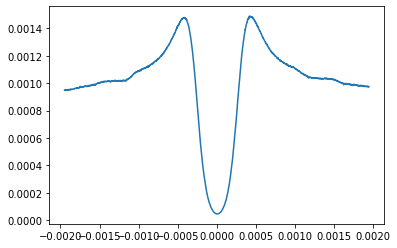

In [4]:
#taking the returns of the function
a,b,c,d = openmyfile(path, dc_fac, femto, R)

#plotting the spectrum
plt.plot(a,b)

[1082 1927]
[0.0005333  0.00051556]
-0.00040709019999999994


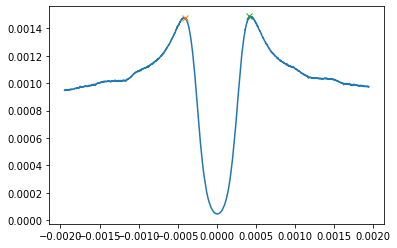

In [7]:
#Finding the center of the peak

#Method 1: Using a built-in function scipy.signal.find_peaks

peakind, properties = find_peaks(b, distance=750,  prominence=(2e-05, 5.33296e-03))
print(peakind)
print(properties['prominences'])

plt.plot(a,b)

for i in range(0,len(peakind)):
    plt.plot(a[peakind[i]], b[peakind[i]], 'x')

#Method 2: Creating own function. Risk (as per Freek, might not work for noisy data) 

#mid=int(len(b)/2)

#Left Peak
#bleft=b[:mid]
#idxleft = [i for i, val in enumerate(bleft) if val == max(bleft)]

#Right Peak
#bright=b[mid:]
#idxright = [i for i, val in enumerate(bright) if val == max(bright)]

#print()

#Center
C=(a[peakind[0]]+a[peakind[0]])*0.5
print(C)

#Spectrum Centering
a_new = [x-C for x in a] #it doesnt matter whether C is posotive or negative the formula will do the same thing

#plt.plot(a,b, color='black')  
#plt.plot(a_new, b, color='red')
#plt.xlim(0.0002,0.0008)
#plt.ylim(0.0007,0.0016)

(-3.5e-08, 3.5e-08)

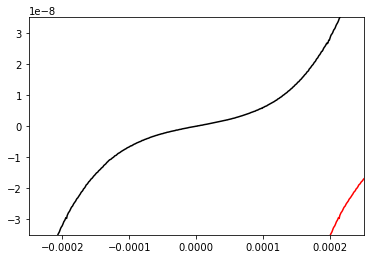

In [8]:
#Plotting the IV curve (v (a) vs v_centered (a_new))
plt.plot(a, d, color='black')
plt.plot(a_new, d, color='red')
plt.xlim(-0.00025,0.00025)
plt.ylim(-0.000000035,0.000000035)

In [ ]:
print(a[peakind[1]]-a[peakind[0]])

0.0
1082
-2.384199e-07


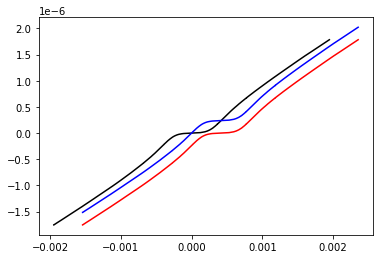

In [10]:
#Finding the index of V_bias=0

#idx_x0 = np.where(np.array(a_new) == float(0))
#print(a_new)

#print(min(b))
#print(idx_x0)

#The minimum of the entire dI/dV spectrum corresponds to the middle of the flatline in the IV curve.

#So first want the index of of the minimum of the dI/dV, and we will use the same index to identify the corresponding current.

z=min(np.absolute(a_new)) #take the absolute value of the a_new and find the minimum, which corresponds to the number closest to zero if it is not zero. 
min_a_idx= a_new.index(z) #Find the index of that minimum element of a_new
y_offset= d[min_a_idx] # y-offset is defined by the current value at the zero bias.
d_new = [x-y_offset for x in d] # d_new is the checked current

#print(d_new)

#with a_new and d_new being foud we can now treat the perfectly centered IV curve and work from there


plt.plot(a, d, color='black')
plt.plot(a_new, d, color='red')
plt.plot(a_new, d_new, color='blue')
print(z)
print(min_a_idx)
print(y_offset)
#plt.xlim(-0.00009,0.00009)
#plt.ylim(-0.0000000035,0.0000000035)


#print(np.all(a_new))

#print(min(np.absolute(a_new)))
#z=min(np.absolute(a_new))
#Min_a_idx= a_new.index(z)
#print(a_new[1505])
#print(Min_a_idx)

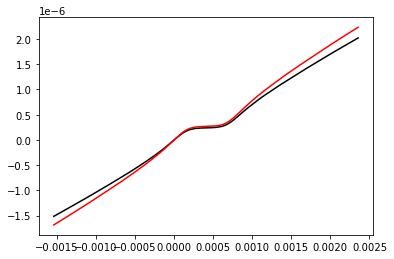

In [11]:
#Sanity Check
#Next we want to integrate the g (g_int) and compare it with i

g_integration = integrate.cumtrapz(b,a_new)

g_integ=np.append(g_integration, g_integration[-1])

I_offset = g_integ[min_a_idx]
g_int = [x-I_offset for x in g_integ]


plt.plot(a_new, d_new, color='black')
plt.plot(a_new, g_int, color='red')



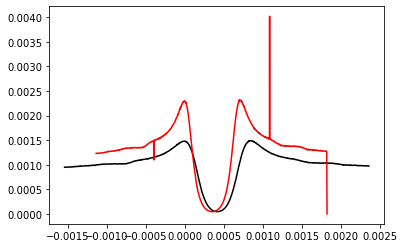

In [12]:
# Next we want to compute the corrected g, by calculating dI/dV. but instead of using I, we use the
#integrated g (g_int), differentiated with the corrected V.

#First we want to eliminate the femto, noting that the femto resistance is 120Ohms for 10^6 amplification, and assuming that the R_lines=120Ohms in total so the series resistance is equal to 140Ohms

R_femto=120
R_lines=120
R_ser= R_femto + R_lines

v_corr= [y - x*R_ser for y, x in zip(a_new,g_int)]

#print(len(g_int))
#print(len(v_corr))

#next, we take the derivative of g_int wrt the v_corr

dI_dV = np.gradient(g_int, v_corr)

plt.plot(a_new, b, color='black')
plt.plot(v_corr, dI_dV, color='red')


#plt.xlim(-0.0008,-0.0007)
#plt.ylim(0.0010,0.0017)

In [20]:
f=v_corr
varargs=g_int

print(len(v_corr.shape))
print(len(g_int))

AttributeError: 'list' object has no attribute 'shape'

In [25]:
f=v_corr
varargs= (x for x in g_int)


def gradientO4(f, *varargs):
    """Calculate the fourth-order-accurate gradient of an N-dimensional scalar function.
    Uses central differences on the interior and first differences on boundaries
    to give the same shape.
    Inputs:
      f -- An N-dimensional array giving samples of a scalar function
      varargs -- 0, 1, or N scalars giving the sample distances in each direction
    Outputs:
      N arrays of the same shape as f giving the derivative of f with respect
       to each dimension.
    """
    N = len(f.shape)  # number of dimensions
    n = len(varargs)
    print(N)
    print(n)
    if n == 0:
        dx = [1.0]*N
    elif n == 1:
        dx = [varargs[0]]*N
    elif n == N:
        dx = list(varargs)
    else:
        raise SyntaxError, "invalid number of arguments"

    # use central differences on interior and first differences on endpoints

    #print dx
    outvals = []

    # create slice objects --- initially all are [:, :, ..., :]
    slice0 = [slice(None)]*N
    slice1 = [slice(None)]*N
    slice2 = [slice(None)]*N
    slice3 = [slice(None)]*N
    slice4 = [slice(None)]*N

    otype = f.dtype.char
    if otype not in ['f', 'd', 'F', 'D']:
        otype = 'd'

    for axis in range(N):       
        # select out appropriate parts for this dimension
        out = np.zeros(f.shape, f.dtype.char)

        slice0[axis] = slice(2, -2)
        slice1[axis] = slice(None, -4)
        slice2[axis] = slice(1, -3)
        slice3[axis] = slice(3, -1)
        slice4[axis] = slice(4, None)
        # 1D equivalent -- out[2:-2] = (f[:4] - 8*f[1:-3] + 8*f[3:-1] - f[4:])/12.0
        out[slice0] = (f[slice1] - 8.0*f[slice2] + 8.0*f[slice3] - f[slice4])/12.0

        slice0[axis] = slice(None, 2)
        slice1[axis] = slice(1, 3)
        slice2[axis] = slice(None, 2)
        # 1D equivalent -- out[0:2] = (f[1:3] - f[0:2])
        out[slice0] = (f[slice1] - f[slice2])

        slice0[axis] = slice(-2, None)
        slice1[axis] = slice(-2, None)
        slice2[axis] = slice(-3, -1)
        ## 1D equivalent -- out[-2:] = (f[-2:] - f[-3:-1])
        out[slice0] = (f[slice1] - f[slice2])


        # divide by step size
        outvals.append(out / dx[axis])

        # reset the slice object in this dimension to ":"
        slice0[axis] = slice(None)
        slice1[axis] = slice(None)
        slice2[axis] = slice(None)
        slice3[axis] = slice(None)
        slice4[axis] = slice(None)

    if N == 1:
        return outvals[0]
    else:
        return outvals

SyntaxError: invalid syntax (3749318557.py, line 27)

In [ ]:
a=[1,2,3]

b= 2 in a

print(b)

In [ ]:
print(a.size)

In [ ]:
#print(a)

peakindp, propertiesp = find_peaks(dIdV_189, prominence=(2.5e-3, 0.05))
#print(peakindp)
for i in range(len(peakindp)):
        plt.plot(v_corr_189[peakindp[i]]*1e3, dIdV_189[peakindp[i]]*1e3, 'x')
        #dIdV_189[peakindp[i]-2]=0
        dIdV_189[peakindp[i]-1]=0
        dIdV_189[peakindp[i]]=0
        dIdV_189[peakindp[i]+1]=0
        #dIdV_189[peakindp[i]+2]=0
        for j in range(-1,4):
            dIdV_189[peakindp[i]-1] += dIdV_189[peakindp[i]-1+j]/2
        for k in range(-11,12):
            dIdV_189[peakindp[i]+1] += dIdV_189[peakindp[i]+1+j]/20
        for l in range(-11,12):
            dIdV_189[peakindp[i]] += dIdV_189[peakindp[i]+j]/21
            
#ADD MORE POINTS        
        
peakindn, propertiesn = find_peaks(-dIdV_189, prominence=(3.5e-4, 5e-4))
#print(peakindn)
for i in range(len(peakindn)):
        plt.plot(v_corr_189[peakindn[i]]*1e3, dIdV_189[peakindn[i]]*1e3, 'x')
        #dIdV_189[peakindp[i]-2]=0
        dIdV_189[peakindn[i]-1]=0
        dIdV_189[peakindn[i]]=0
        dIdV_189[peakindn[i]+1]=0
        #dIdV_189[peakindp[i]+2]=0
        for j in range(-5,6):
            dIdV_189[peakindn[i]-1] += dIdV_189[peakindn[i]-1+j]/7
        for k in range(-5,6):
            dIdV_189[peakindn[i]+1] += dIdV_189[peakindn[i]+1+j]/8
        for l in range(-5,6):
            dIdV_189[peakindn[i]] += dIdV_189[peakindn[i]+j]/9
    
plt.plot([x*1e3 for x in v_corr_189],[y*1e3 for y in dIdV_189])
print(dIdV_189[499])        
print(dIdV_189[2500])

In [ ]:
def Remove_DiracOutliers(dIdV)
    
    #Positive peaks
    peakindp, propertiesp = find_peaks(dIdV, prominence=(3e-3, 0.05))
    for i in range len(peakindp):
        dIdV[i] = (dIdV[i-1]+dIdV[1+1])/2
    #Negative peaks
    peakindn, propertiesn = find_peaks(-dIdV, prominence=(3.5e-4, 5e-4))
    for j in range len(peakindp):
        dIdV[j] = (dIdV[j-1]+dIdV[j+1])/2
        
    dIdV[-1] = dIdV[-2]
    
    return dIdV
    
    
for i in range(0,len(peakindn)):
        plt.plot(v_corr_189[peakindn[i]]*1e3, dIdV_189[peakindn[i]]*1e3, 'x')
    
    
    
plt.plot([x*1e3 for x in v_corr_189],[y*1e3 for y in dIdV_189])
#print(a)

peakindp, propertiesp = find_peaks(dIdV_189, prominence=(3e-3, 0.05))
for i in range(0,len(peakindp)):
        plt.plot(v_corr_189[peakindp[i]]*1e3, dIdV_189[peakindp[i]]*1e3, 'x')
        
peakindn, propertiesn = find_peaks(-dIdV_189, prominence=(3.5e-4, 5e-4))
for i in range(0,len(peakindn)):
        plt.plot(v_corr_189[peakindn[i]]*1e3, dIdV_189[peakindn[i]]*1e3, 'x')
        
#print(peakindn)
print(propertiesn)
#print(max(propertiesn[0]))
print(len(peakindn))